In [1]:
import pandas as pd
from pandas import Series, DataFrame, Panel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import sklearn
import scipy
import scipy.ndimage
import seaborn as sns
from PIL import Image
%matplotlib inline

In [2]:
# Загружаем MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

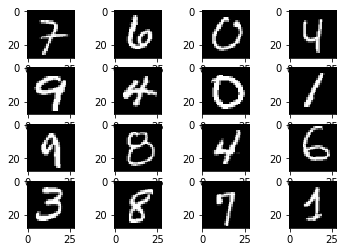

In [4]:
import scipy
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    #print(I.shape)
    plt.imshow(I, cmap='gray')
#(X[np.random.randint(0, X.shape[0]),0])

In [5]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)
Y_enc = np.zeros((len(Y), 10))
for i in range(len(Y)):
  Y_enc[i, Y[i]] = 1
Y_enc

original [5 0 4 ... 4 5 6]


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('conv_1', nn.Conv2d(1, 32, kernel_size=(3,3), stride=1))
        self.net.add_module('relu_1', nn.ReLU())
        self.net.add_module('conv_2', nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)) 
        self.net.add_module('relu_2', nn.ReLU())
        self.net.add_module('drop_1', nn.Dropout(0.1))                  
        self.fc1 = nn.Linear(64*24*24, 128)
        self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 64 * 24 * 24)
        x = self.fc2(self.drop2(F.relu(self.fc1(x))))
        return x


class MLPNet(nn.Module):

    def __init__(self):
        super(MLPNet, self).__init__()
        self.net = nn.Sequential()                 
        self.fc1 = nn.Linear(28*28, 200)
        self.drop2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 28*28)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x


## Функция обучения модели

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

def fit_net(c_epoch, net, X, Y):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    net = net.train()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_train[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_train[batch_idxs]).long().to(DEVICE))
            y_pred = F.softmax(net(x), -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    return net

def experiment_vanilla(net, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [8]:
def experiment_ensemble(nets, X, Y, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    for i in range(len(nets)):
        nets[i] = nets[i].to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for net in nets:
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= len(nets)

            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [9]:
def fit_net_T(c_epoch, net, X, Y):
    loss_fn = torch.nn.NLLLoss()
    

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(DEVICE)
    
    class T_net(nn.Module):
        def __init__(self):
            super(T_net, self).__init__()
            self.T = nn.Parameter(torch.FloatTensor([1.]))
            
        def forward(self, x):
            return F.log_softmax(Variable(net(x))*self.T, -1)
    t_net = T_net().to(DEVICE)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test, test_size=0.7, random_state=97)
    optimizer = torch.optim.Adam(t_net.parameters(), lr=learning_rate)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_val.shape[0])
        loss_acc = 0
        nbatches = X_val.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_val[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_val[batch_idxs]).long().to(DEVICE))
            y_pred = t_net(x) # F.log_softmax(Variable(net(x))/T, -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('T optimization: Do epoch %s with loss %s T = %s' % (iter, avg_epoch_loss, 1./t_net.T.data.item()))
        loss_curve.append(avg_epoch_loss)
    return t_net.T.data.item()

    
    

def experiment_temperature(net, X, Y, T, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]*T))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

In [10]:
def experiment_dropout(net, X, Y, n_iter=10, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for it in range(n_iter):
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= n_iter
            
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

### Обучаем модели


In [11]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_van = net_v.eval()
loss_curve_translate_vanilla , brier_curve_translate_vanilla = experiment_vanilla(model_van, X,Y, translate=True)
loss_curve_rotate_vanilla , brier_curve_rotate_vanilla = experiment_vanilla(model_van, X,Y, rotate=True)
loss_curve_blur_vanilla , brier_curve_blur_vanilla = experiment_vanilla(model_van, X,Y, blur=True)

Do epoch 0 with loss 1.6843149072359869
Do epoch 1 with loss 1.5138567167335257
Do epoch 2 with loss 1.5015883647616142
Do epoch 3 with loss 1.4959008665585696
Do epoch 4 with loss 1.4912797809286005
Do epoch 5 with loss 1.4894045871170387
Do epoch 6 with loss 1.4884021823940297
Do epoch 7 with loss 1.4859194225309236
Do epoch 8 with loss 1.4849418324417367
Do epoch 9 with loss 1.483127674616929


In [12]:
nets_ens = []
for i in range(10):
    net = LeNet()
    nets_ens.append(fit_net(10, net, X, Y).eval())
loss_curve_translate_ensemble , brier_curve_translate_ensemble = experiment_ensemble(nets_ens, X,Y, translate=True)
loss_curve_rotate_ensemble , brier_curve_rotate_ensemble = experiment_ensemble(nets_ens, X,Y, rotate=True)
loss_curve_blur_ensemble , brier_curve_blur_ensemble = experiment_ensemble(nets_ens, X,Y, blur=True)

Do epoch 0 with loss 1.653548256632855
Do epoch 1 with loss 1.514393222996404
Do epoch 2 with loss 1.5039227873182757
Do epoch 3 with loss 1.4960309286209548
Do epoch 4 with loss 1.4937496203190517
Do epoch 5 with loss 1.4879386628811255
Do epoch 6 with loss 1.4881594014959958
Do epoch 7 with loss 1.484493808219926
Do epoch 8 with loss 1.4835616996050647
Do epoch 9 with loss 1.4830472176736829
Do epoch 0 with loss 1.7230297206299099
Do epoch 1 with loss 1.5203483480349231
Do epoch 2 with loss 1.505347303063923
Do epoch 3 with loss 1.4979673332084542
Do epoch 4 with loss 1.4926827007551284
Do epoch 5 with loss 1.4900085669877317
Do epoch 6 with loss 1.4889335507109744
Do epoch 7 with loss 1.4860644994058025
Do epoch 8 with loss 1.4848719373393289
Do epoch 9 with loss 1.484073777099131
Do epoch 0 with loss 1.762034523525422
Do epoch 1 with loss 1.612769816657738
Do epoch 2 with loss 1.5261799864319232
Do epoch 3 with loss 1.5036020857728178
Do epoch 4 with loss 1.4978152220911023
Do epoc

In [13]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_temp = net_v.eval()
temperature = fit_net_T(20, model_temp, X, Y)
loss_curve_translate_temp, brier_curve_translate_temp = experiment_temperature(model_temp, X,Y,temperature, translate=True)
loss_curve_rotate_temp, brier_curve_rotate_temp = experiment_temperature(model_temp, X,Y,temperature, rotate=True)
loss_curve_blur_temp , brier_curve_blur_temp = experiment_temperature(model_temp, X,Y,temperature, blur=True)

Do epoch 0 with loss 1.6852241426802141
Do epoch 1 with loss 1.5148289280944571
Do epoch 2 with loss 1.5006918868834567
Do epoch 3 with loss 1.494344523162576
Do epoch 4 with loss 1.4909956080864992
Do epoch 5 with loss 1.4870142427543607
Do epoch 6 with loss 1.4860273082156656
Do epoch 7 with loss 1.4837660813127171
Do epoch 8 with loss 1.4815209450445759
Do epoch 9 with loss 1.481459371146665
T optimization: Do epoch 0 with loss 0.2525942655409248 T = 1.0071556536411266
T optimization: Do epoch 1 with loss 0.25106182103640934 T = 1.0130885221573502
T optimization: Do epoch 2 with loss 0.24958625924399222 T = 1.018962714534684
T optimization: Do epoch 3 with loss 0.24810951924699073 T = 1.02562563917381
T optimization: Do epoch 4 with loss 0.24657024170611755 T = 1.0317417787191132
T optimization: Do epoch 5 with loss 0.24506616402540604 T = 1.0384129229217496
T optimization: Do epoch 6 with loss 0.24350716839522712 T = 1.0452384230603653
T optimization: Do epoch 7 with loss 0.2419506

In [14]:
net = LeNet()
net_drop = fit_net(10, net, X, Y)
loss_curve_translate_drop, brier_curve_translate_drop = experiment_dropout(net_drop, X,Y, translate=True)
loss_curve_rotate_drop, brier_curve_rotate_drop = experiment_dropout(net_drop, X,Y, rotate=True)
loss_curve_blur_drop , brier_curve_blur_drop = experiment_dropout(net_drop, X,Y, blur=True)

Do epoch 0 with loss 1.67714827122029
Do epoch 1 with loss 1.514532896164018
Do epoch 2 with loss 1.501869150488323
Do epoch 3 with loss 1.4945466095483826
Do epoch 4 with loss 1.4915488430669197
Do epoch 5 with loss 1.4891682662636776
Do epoch 6 with loss 1.4849400683870142
Do epoch 7 with loss 1.4832434985798655
Do epoch 8 with loss 1.4823824268189785
Do epoch 9 with loss 1.4824365261794414


 ## Результаты

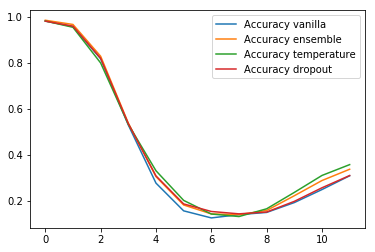

In [15]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_rotate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_rotate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_rotate_temp,label="Accuracy temperature")
ax.plot(loss_curve_rotate_drop,label="Accuracy dropout")
ax.legend()
plt.show()

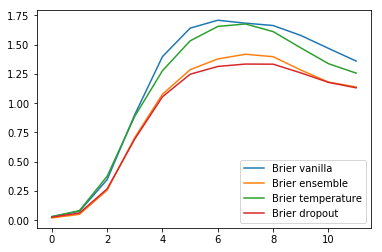

In [16]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_rotate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_rotate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_rotate_temp,label="Brier temperature")
ax.plot(brier_curve_rotate_drop,label="Brier dropout")
ax.legend()
plt.show()

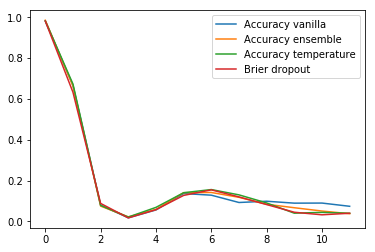

In [17]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_translate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_translate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_translate_temp,label="Accuracy temperature")
ax.plot(loss_curve_translate_drop,label="Brier dropout")
ax.legend()
plt.show()

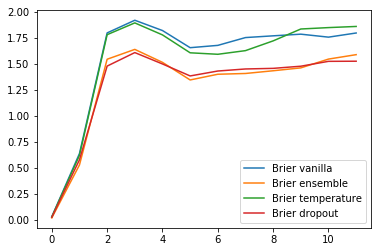

In [18]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_translate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_translate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_translate_temp,label="Brier temperature")
ax.plot(brier_curve_translate_drop,label="Brier dropout")
ax.legend()
plt.show()

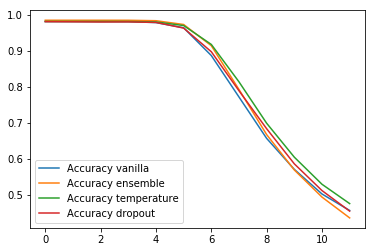

In [19]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_blur_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_blur_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_blur_temp,label="Accuracy temperature")
ax.plot(loss_curve_blur_drop,label="Accuracy dropout")
ax.legend()
plt.show()

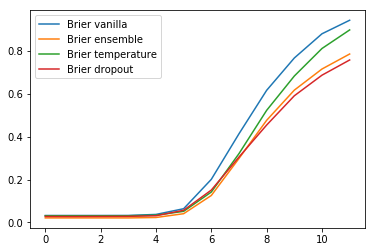

In [20]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_blur_vanilla,label="Brier vanilla")
ax.plot(brier_curve_blur_ensemble,label="Brier ensemble")
ax.plot(brier_curve_blur_temp,label="Brier temperature")
ax.plot(brier_curve_blur_drop,label="Brier dropout")
ax.legend()
plt.show()

### Проверим энтропию предсказаний

In [21]:
cifar = fetch_openml('CIFAR_10_small')
oodX = cifar['data']
oodX = oodX.reshape((-1, 3, 32, 32))
oodX = oodX.astype('float')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

oodX = rgb2gray(np.transpose(oodX[:,:,2:-2,2:-2], (0, 2, 3, 1))/255)
oodX = oodX.reshape((-1, 1, 28, 28))
print(oodX.shape)

(20000, 1, 28, 28)


(20000, 1, 28, 28)


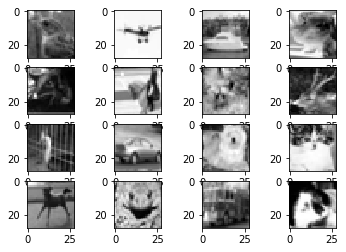

In [22]:
import scipy

print(oodX.shape)
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = oodX[np.random.randint(0, oodX.shape[0]), 0]
    #print(I.shape)
    plt.imshow(I, cmap='gray')

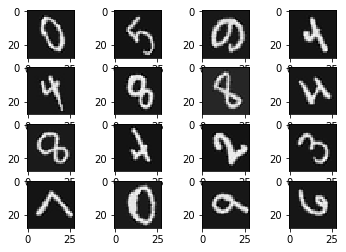

In [23]:
shiftX = scipy.ndimage.rotate(X[:oodX.shape[0], :, :, :], 50, axes=(2,3))
shiftX = shiftX[:,:, int(shiftX.shape[2]/2 - 14) : int(shiftX.shape[2]/2 + 14), int(shiftX.shape[3]/2 - 14) : int(shiftX.shape[3]/2 + 14)]
valX = X[:oodX.shape[0], :, :, :]
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = shiftX[np.random.randint(0, shiftX.shape[0]),0]
    #print(I.shape)
    plt.imshow(I, cmap='gray')

In [31]:
def entropy_van(model, x):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        y = scipy.special.softmax(model(xb).cpu().detach().numpy(), -1)
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)

def entropy_drop(model, x, n_iter = 10):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        y = np.zeros((BATCH_SIZE, 10))
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        for i in range(n_iter):
            y += scipy.special.softmax(model(xb).cpu().detach().numpy(), -1)/n_iter
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)
    
def entropy_temp(model, T, x, n_iter = 10):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        y = scipy.special.softmax(model(xb).cpu().detach().numpy() / T, -1)
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)

def entropy_ensamble(models, x, n_iter = 10):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        y = np.zeros((BATCH_SIZE, 10))
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        for model in models:
            y += scipy.special.softmax(model(xb).cpu().detach().numpy(), -1) / len(models)
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)

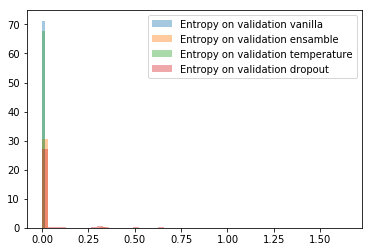

In [32]:
sns.distplot(entropy_van(model_van, valX), label='Entropy on validation vanilla', kde=False, norm_hist=True)
sns.distplot(entropy_ensamble(nets_ens, valX), label='Entropy on validation ensamble', kde=False, norm_hist=True)
sns.distplot(entropy_temp(model_temp, temperature, valX), label='Entropy on validation temperature', kde=False, norm_hist=True)
sns.distplot(entropy_drop(net_drop, valX), label='Entropy on validation dropout', kde=False, norm_hist=True)
plt.legend()
plt.show()

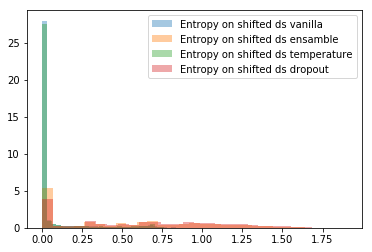

In [33]:
sns.distplot(entropy_van(model_van, shiftX), label='Entropy on shifted ds vanilla', kde=False, norm_hist=True)
sns.distplot(entropy_ensamble(nets_ens, shiftX), label='Entropy on shifted ds ensamble', kde=False, norm_hist=True)
sns.distplot(entropy_temp(model_temp,temperature, shiftX), label='Entropy on shifted ds temperature', kde=False, norm_hist=True)
sns.distplot(entropy_drop(net_drop, shiftX), label='Entropy on shifted ds dropout', kde=False, norm_hist=True)
plt.legend()
plt.show()

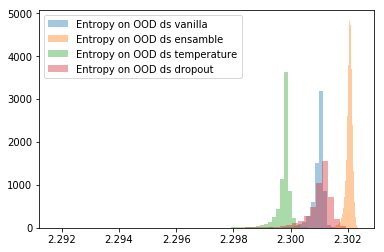

In [34]:
sns.distplot(entropy_van(model_van, oodX), label='Entropy on OOD ds vanilla', kde=False, norm_hist=True)
sns.distplot(entropy_ensamble(nets_ens, oodX), label='Entropy on OOD ds ensamble', kde=False, norm_hist=True)
sns.distplot(entropy_temp(model_temp,temperature, oodX), label='Entropy on OOD ds temperature', kde=False, norm_hist=True)
sns.distplot(entropy_drop(net_drop, oodX), label='Entropy on OOD ds dropout', kde=False, norm_hist=True)
plt.legend()
plt.show()